In [1]:
import io
import google.auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
from datetime import datetime
import os
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vnstock as vns
import copy

In [3]:
def download_record(real_file_id):
    TODAY = datetime.now().strftime("%Y%m%d")
    
    record_today = f'record_{TODAY}.xlsx'
    
    if not os.path.exists(record_today):
        SCOPES = ['https://www.googleapis.com/auth/drive.readonly']
        creds = None
        # The file token.json stores the user's access and refresh tokens, and is
        # created automatically when the authorization flow completes for the first
        # time.
        if os.path.exists('token.json'):
            creds = Credentials.from_authorized_user_file('token.json', SCOPES)
        # If there are no (valid) credentials available, let the user log in.
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file(
                    'credentials.json', SCOPES)
                creds = flow.run_local_server(port=0)
            # Save the credentials for the next run
            with open('token.json', 'w') as token:
                token.write(creds.to_json())

        try:
            # create drive api client
            service = build('drive', 'v3', credentials=creds)

            file_id = real_file_id

            # pylint: disable=maybe-no-member
            request = service.files().export_media(fileId=file_id, mimeType='application/vnd.openxmlformats-officedocument.spreadsheetml.sheet')
            file = io.FileIO(f'record_{TODAY}.xlsx', 'wb')
            downloader = MediaIoBaseDownload(file, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
                print(F'Download {int(status.progress() * 100)}.')

        except HttpError as error:
            print(F'An error occurred: {error}')
            file = None
    return record_today

# CALCULATE STOCK ASSETS

In [4]:
def accumulate_asset_intraday(curr_data: pd.DataFrame, prev_data: dict):
    result = copy.deepcopy(prev_data)
    sell_df = curr_data[~curr_data['Giá bán'].isnull()]
    buy_df = curr_data[curr_data['Giá bán'].isnull()]
    
    for i, r in buy_df.iterrows():
        mcp = r['Mã Đầu tư']
        scp = r['KL giao dịch']
        if mcp is not np.nan:
            result[mcp] = result.get(mcp, 0) + scp
    
    for i, r in sell_df.iterrows():
        mcp = r['Mã Đầu tư']
        scp = r['KL giao dịch']
        if mcp in prev_data.keys():
            result[mcp] = result.get(mcp, 0) - scp
            
    # Check zero asset to remove them
    removed_key = []
    for k, v in result.items():
        if v == 0:
            removed_key.append(k)
    for k in removed_key:
        del result[k]
    return result

In [5]:
def calculate_asset_intraday(record_data):
    asset_intraday = {}
    prev_data = {}
    begin = pd.to_datetime(record_data['Ngày'].min()).strftime('%Y-%m-%d')
    for date, dfg in record_data.groupby('Ngày'):
        curr_data = dfg
        if date == begin:
            asset_intraday[date] = dict(zip(dfg['Mã Đầu tư'].tolist(), dfg['KL giao dịch'].tolist()))
        else:
            asset_intraday[date] = accumulate_asset_intraday(curr_data, prev_data)
        prev_data = asset_intraday[date]
    return asset_intraday

In [6]:
def calculate_stock_assets(df):
    def calculate_assets_per_investor(assets):
        assets['Ngày giao dịch'] = assets['Thời gian giao dịch'].apply(lambda x:datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
        now = datetime.now()
        begin = pd.to_datetime(assets['Thời gian giao dịch'].min()).strftime('%Y-%m-%d')
        asset_date_range = pd.date_range(start=begin, end=now)
        asset_record = pd.DataFrame(data={'Ngày': asset_date_range})
        asset_record = asset_record.merge(assets.drop(columns=['Chủ tài khoản', 'Thời gian giao dịch']),how='left',left_on='Ngày', right_on='Ngày giao dịch')
        asset_record['Ngày'] = asset_record['Ngày'].apply(lambda x:x.strftime('%Y-%m-%d'))
        asset_intraday = calculate_asset_intraday(asset_record)
        return asset_intraday
    
    investor_assets = {}
    for investor, d in df.groupby('Chủ tài khoản'):
        assets = d.sort_values('Thời gian giao dịch')
        asset_intraday = calculate_assets_per_investor(assets)
        investor_assets[investor] = asset_intraday
    return investor_assets

In [7]:
def calculate_capital_intraday(capital_data):
    begin = capital_data['Date'].min()
    prev_data = None
    for idx, r in capital_data.iterrows():
        if r['Date'] == begin:
            capital_data.at[idx, 'Total Capital'] = r['Gửi tiền mặt']
        else:
            if pd.isna(r['TS khớp lệnh mua']) and pd.isna(r['TS khớp lệnh bán']):
                capital_data.at[idx, 'Gửi tiền mặt'] = capital_data.at[idx-1, 'Gửi tiền mặt']
            elif not pd.isna(r['TS khớp lệnh mua']) and pd.isna(r['TS khớp lệnh bán']):
                capital_data.at[idx, 'Gửi tiền mặt'] = capital_data.at[idx-1, 'Gửi tiền mặt'] - r['TS khớp lệnh mua']
                capital_data.at[idx, 'Total Capital'] = capital_data.at[idx, 'Gửi tiền mặt'] + r['TS khớp lệnh mua']
            elif pd.isna(r['TS khớp lệnh mua']) and not pd.isna(r['TS khớp lệnh bán']):
                capital_data.at[idx, 'Gửi tiền mặt'] = capital_data.at[idx-1, 'Gửi tiền mặt'] + r['TS khớp lệnh bán']
                capital_data.at[idx, 'Total Capital'] = capital_data.at[idx, 'Gửi tiền mặt']
            else:
                raise Exception('This case should not happen')
                
    # capital_data[['Date','Gửi tiền mặt']].set_index('Date').plot(grid=True)
    # display(capital_data)
    return capital_data

In [8]:
def calculate_capital(capital, stock_txn):
    stock_txn['Date'] = stock_txn['Thời gian giao dịch'].apply(lambda x:datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    total_abs_capital = capital.groupby('Khách hàng')['Số tiền'].sum() # total capital up-to-date
    customer_lifespan = capital.groupby('Khách hàng')['Thời điểm gửi'].min()
    capital_records = {}
    for customer in customer_lifespan.index:
        customer_stock_data = stock_txn[stock_txn['Chủ tài khoản']==customer]
        begin = customer_lifespan[customer]
        end = datetime.now().date()
        capital_date_range = pd.date_range(start=begin, end=end)
        capital_data = pd.DataFrame({'Date': capital_date_range})
        capital_data = capital_data.merge(customer_stock_data, how='left', left_on='Date', right_on='Date')
        capital_data['Chủ tài khoản'] = customer
        capital_data = capital_data.merge(capital, how='left', left_on=['Date', 'Chủ tài khoản'], right_on=['Thời điểm gửi', 'Khách hàng'])
        capital_data = capital_data.drop(columns=['Thời điểm gửi', 'Khách hàng'])
        capital_data = capital_data.rename(columns={'Số tiền': 'Gửi tiền mặt'})
        capital_data['Total Capital'] = np.nan
        capital_data = calculate_capital_intraday(capital_data)
        capital_records[customer] = capital_data
    return capital_records

In [81]:
def calculate_total_capital(capital_records, stock_assets):
    def correct_total_capital(x):
        result = np.nan
        if not pd.isna(x['Total Capital']):
            result = x['Total Capital']
        else:
            if pd.isna(x['Value']):
                result = x['Gửi tiền mặt']
            else:
                result = x['Gửi tiền mặt'] + x['Value']
        return result
    
    customer_total_capital = {}
    for customer in capital_records.keys():
        capital = capital_records[customer]
        customer_stock_assets = stock_assets[customer]
        total_capital = capital.merge(customer_stock_assets, how='left', left_on='Date', right_on='Date')
        total_capital['Total Capital Final'] = total_capital[['Gửi tiền mặt', 'Total Capital', 'Value']].apply(lambda x: correct_total_capital(x),axis = 1)
        total_capital = total_capital[['Date', 'Chủ tài khoản', 'Thời gian giao dịch', 'Mã Đầu tư', 'KL giao dịch', 'Giá mua', 'TS khớp lệnh mua', 'Giá bán', 'TS khớp lệnh bán', 'Gửi tiền mặt', 'Value', 'Total Capital Final']]
        total_capital = total_capital.rename(columns={'Gửi tiền mặt': 'Tiền mặt', 'Value': 'Stock value', 'Total Capital Final': 'Total Capital'})
        total_capital = total_capital.merge(customer_stock_assets, how='right', left_on='Date', right_on='Date')
        display(total_capital)
        customer_total_capital[customer] = total_capital
    return customer_total_capital

In [82]:
def read_record(record):
    capital = pd.read_excel(record, sheet_name='Vốn đầu tư')
    stock_txn = pd.read_excel(record, sheet_name='Hoạt động giao dịch')
    # Capital and cash
    capital_records = calculate_capital(capital, stock_txn)
    # Stock activities
    stock_assets = calculate_stock_assets(stock_txn)
    return capital_records, stock_assets

In [83]:
def query_stock_data(investor_assets):
    investor_stockids = {}
    for i, assets_intraday in investor_assets.items():
        stockids = []
        for d, a in assets_intraday.items():
            stockids.extend(list(a.keys()))
        stockids = set(stockids)
        investor_stockids[i] = stockids
    
    investor_asset_values = {}
    for i in investor_assets.keys():
        inv_df = pd.DataFrame(investor_assets[i]).transpose()
        inv_df.index = pd.to_datetime(inv_df.index, format='%Y-%m-%d')
        assets = pd.DataFrame(columns=['Date', 'Value'])
        for s in investor_stockids[i]:
            stock_df = inv_df[s].dropna()
            start_date = stock_df.index.min().strftime('%Y-%m-%d')
            end_date = stock_df.index.max().strftime('%Y-%m-%d')
            sel_stock_data = vns.stock_historical_data(symbol=s, start_date=start_date, end_date=end_date)
            merge_stock = stock_df.to_frame().merge(sel_stock_data, how='inner', left_index=True, right_on='TradingDate')
            merge_stock['Value'] = merge_stock[s] * merge_stock['Close']
            merge_stock['Date'] = merge_stock['TradingDate']
            assets = pd.concat([assets, merge_stock[['Date', 'Value']]], ignore_index=True)
        assets['Date'] = pd.to_datetime(assets['Date'],format='%Y-%m-%d')
        assets = assets.sort_values('Date').reset_index(drop=True)
        investor_asset_values[i] = assets
    return investor_asset_values

In [84]:
def plot_total_assets(stock_data):
    for i, a in stock_data.items():
        diagram = a[['Date', 'Total Capital']].set_index('Date')
        diagram.plot(grid=True, title=f'Kết quả đầu tư của khách hàng {i}')
        plt.show()
        display(a)

In [85]:
def report_stock():
    record = download_record('1OreCLhSU6UuO8K5SZp8IpqcSZUx1Yq9QJb6PafPvP7M')
    capital_records, investor_assets = read_record(record)
    stock_assets = query_stock_data(investor_assets)
    # Total assets
    total_assets = calculate_total_capital(capital_records, stock_assets)
    plot_total_assets(total_assets)
    return total_assets

,Date,Chủ tài khoản,Thời gian giao dịch,Mã Đầu tư,KL giao dịch,Giá mua,TS khớp lệnh mua,Giá bán,TS khớp lệnh bán,Tiền mặt,Stock value,Total Capital,Value
0,2023-02-21,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8220000.0,9997600.0,8220000.0
1,2023-02-22,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8070000.0,9847600.0,8070000.0
2,2023-02-23,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8100000.0,9877600.0,8100000.0
3,2023-02-24,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8190000.0,9967600.0,8190000.0
4,2023-02-27,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,7860000.0,9637600.0,7860000.0
5,2023-02-28,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8160000.0,9937600.0,8160000.0
6,2023-03-01,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8550000.0,10327600.0,8550000.0
7,2023-03-02,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8325000.0,10102600.0,8325000.0
8,2023-03-03,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8100000.0,9877600.0,8100000.0
9,2023-03-06,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8115000.0,9892600.0,8115000.0


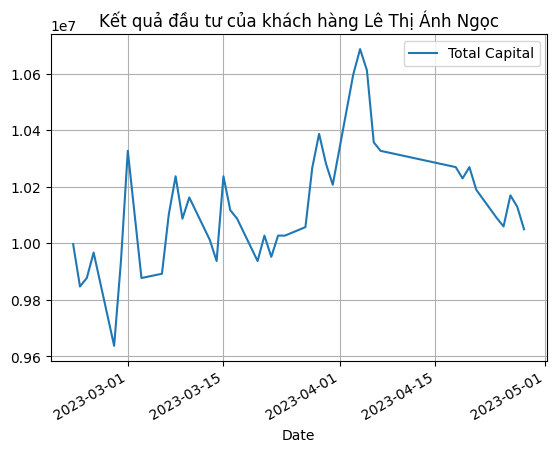

,Date,Chủ tài khoản,Thời gian giao dịch,Mã Đầu tư,KL giao dịch,Giá mua,TS khớp lệnh mua,Giá bán,TS khớp lệnh bán,Tiền mặt,Stock value,Total Capital,Value
0,2023-02-21,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8220000.0,9997600.0,8220000.0
1,2023-02-22,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8070000.0,9847600.0,8070000.0
2,2023-02-23,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8100000.0,9877600.0,8100000.0
3,2023-02-24,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8190000.0,9967600.0,8190000.0
4,2023-02-27,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,7860000.0,9637600.0,7860000.0
5,2023-02-28,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8160000.0,9937600.0,8160000.0
6,2023-03-01,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8550000.0,10327600.0,8550000.0
7,2023-03-02,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8325000.0,10102600.0,8325000.0
8,2023-03-03,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8100000.0,9877600.0,8100000.0
9,2023-03-06,Lê Thị Ánh Ngọc,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1777600.0,8115000.0,9892600.0,8115000.0


In [86]:
df = report_stock()